<a href="https://colab.research.google.com/github/sreejithvn/zero-shot-classification-for-long-text/blob/main/2_1_Pytorch_DistilBert_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install datasets
import pandas as pd
import numpy as np

In [ ]:
from sklearn.model_selection import train_test_split
import time
import torch

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_json('/content/gdrive/MyDrive/Colab Notebooks/MSC_Project/Jan2020Frontiers_20_labels.jsonl', lines=True)

In [ ]:
df.head()

,id,text,journal,label,clean_text
0,465950,\n Sleep Characteristics and Influencing Facto...,Frontiers in Medicine,Medicine,sleep characteristics and influencing factors ...
1,483526,A Hybrid Approach for Modeling Type 2 Diabetes...,Frontiers in Genetics,Genetics,a hybrid approach for modeling type diabetes m...
2,437333,Environmental Health Research in Africa: Impor...,Frontiers in Genetics,Genetics,environmental health research in africa: impor...
3,486515,"\n 3,5-T2—A Janus-Faced Thyroid Hormone Metabo...",Frontiers in Endocrinology,Endocrinology,",-—a janus-faced thyroid hormone metabolite ex..."
4,488364,\n Differential Regulation of LPS-Mediated VE-...,Frontiers in Cell and Developmental Biology,Cell and Developmental Biology,differential regulation of lps-mediated ve-cad...


# Convert categorical labels to integers

In [ ]:
labels = list(df.label.unique())
NUM_LABELS = len(labels)

id2label = {index:label for index,label in enumerate(labels)}
label2id = {label:index for index,label in enumerate(labels)}

print(label2id)

{'Medicine': 0, 'Genetics': 1, 'Endocrinology': 2, 'Cell and Developmental Biology': 3, 'Psychiatry': 4, 'Public Health': 5, 'Ecology and Evolution': 6, 'Chemistry': 7, 'Physiology': 8, 'Marine Science': 9, 'Neurology': 10, 'Bioengineering and Biotechnology': 11, 'Earth Science': 12, 'Physics': 13, 'Cellular Neuroscience': 14, 'Neuroscience': 15, 'Veterinary Science': 16, 'Aging Neuroscience': 17, 'Pediatrics': 18, 'Cellular and Infection Microbiology': 19}


In [ ]:
df["label_id"] = df.label.map(lambda x: label2id[x.strip()])
df.head()

,id,text,journal,label,clean_text,label_id
0,465950,\n Sleep Characteristics and Influencing Facto...,Frontiers in Medicine,Medicine,sleep characteristics and influencing factors ...,0
1,483526,A Hybrid Approach for Modeling Type 2 Diabetes...,Frontiers in Genetics,Genetics,a hybrid approach for modeling type diabetes m...,1
2,437333,Environmental Health Research in Africa: Impor...,Frontiers in Genetics,Genetics,environmental health research in africa: impor...,1
3,486515,"\n 3,5-T2—A Janus-Faced Thyroid Hormone Metabo...",Frontiers in Endocrinology,Endocrinology,",-—a janus-faced thyroid hormone metabolite ex...",2
4,488364,\n Differential Regulation of LPS-Mediated VE-...,Frontiers in Cell and Developmental Biology,Cell and Developmental Biology,differential regulation of lps-mediated ve-cad...,3


## SPLITTING DATA into TRAIN, VALIDATION and TEST sets

In [ ]:
# stratify=df.label, To get exact same datasets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(df.clean_text, df.label_id, test_size=0.2, 
                                                                      random_state=42, stratify=df.label, shuffle=True)  

In [ ]:
# While applying stratify, to get the exact same test set (as used for zero-shot)
temp_id2label = temp_labels.map(id2label)

In [ ]:
# stratify=temp_id2label (To get same test and val datasets)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, 
                                                                  random_state=42, stratify=temp_id2label, shuffle=True)

In [ ]:
# reset_indices
train_texts.reset_index(drop=True, inplace=True), train_labels.reset_index(drop=True, inplace=True)
val_texts.reset_index(drop=True, inplace=True), val_labels.reset_index(drop=True, inplace=True)
test_texts.reset_index(drop=True, inplace=True), test_labels.reset_index(drop=True, inplace=True)

(None, None)

In [ ]:
test_texts

0      respiratory morbidity and lung function analys...
1      flavor techniques for lfv processes: higgs dec...
2      corrigendum: human milk oligosaccharide compos...
3      obsessive–compulsive personality symptoms pred...
4      blood-brain barrier and delivery of protein an...
                             ...                        
106    synergies between division of labor and gut mi...
107    efficient and stable photocatalytic hydrogen e...
108    the δ-opioid receptor differentially regulates...
109    thalidomide in the treatment of sweet's syndro...
110    investigating gray and white matter structural...
Name: clean_text, Length: 111, dtype: object

In [ ]:
train_texts.shape, val_texts.shape, test_texts.shape

((880,), (110,), (111,))

In [ ]:
# Each set contains samples from all classes
len(train_labels.unique()), len(val_labels.unique()), len(test_labels.unique())

(20, 20, 20)

In [ ]:
pd.DataFrame([id2label, train_labels.value_counts(), val_labels.value_counts(), test_labels.value_counts()], 
             index=['text_label', 'Train', 'Val', 'Test']).T.sort_values(by='Train', ascending=False)

,text_label,Train,Val,Test
8,Physiology,84,10,11
1,Genetics,79,10,10
15,Neuroscience,71,9,9
4,Psychiatry,69,8,9
10,Neurology,61,7,8
7,Chemistry,55,7,7
9,Marine Science,51,6,7
11,Bioengineering and Biotechnology,45,5,6
2,Endocrinology,42,5,6
3,Cell and Developmental Biology,38,5,4


In [ ]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val 
            in self.encodings.items()}
    
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

In [ ]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
train_dataset = MyDataset(tokenizer(train_texts.tolist(), padding=True, truncation=True), train_labels)
val_dataset = MyDataset(tokenizer(val_texts.tolist(), padding=True, truncation=True), val_labels)
# test_dataset = MyDataset(tokenizer(test_texts.tolist(), padding=True, truncation=True), test_labels)

In [ ]:
from torch.utils.data import DataLoader

# BATCH_SIZE = 32 Ran out of memory for manual Pytorch with DistilBERT in Colab Pro, after 1st training epoch (changed to 16)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

# Define Model and Load to GPU 

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id).to(device)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

## Define Optimizer and Learning rate scheduler. 
Learning rate chosen based on fine-tuning recommendation from BERT paper

In [ ]:
from transformers import AdamW

# optimizer = AdamW(model.parameters(), lr=1e-3)  learning rate, lr = 1e-3, gave exact same accuracy of .509 for all epochs
optimizer = AdamW(model.parameters(), lr=2e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Training Epochs
epochs = 10

total_steps = len(train_loader) * epochs

# Create learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=100,
                                            num_training_steps=total_steps)


## Load Metrics

In [ ]:
import datasets
from datasets import load_metric

train_metric_accuracy = load_metric('accuracy')
val_metric_accuracy = load_metric('accuracy')
test_metric_accuracy_512 = load_metric('accuracy')
test_metric_accuracy = load_metric('accuracy')

train_metric_f1 = load_metric('f1', average='macro')
val_metric_f1 = load_metric('f1', average='macro')
test_metric_f1_512 = load_metric('f1', average='macro')
test_metric_f1 = load_metric('f1', average='macro')

In [ ]:
# torch.cuda.empty_cache()
# import gc
# gc.collect()
# torch.cuda.memory_summary(device=None, abbreviated=False)

# Training and Evaluating the Model

In [ ]:
training_stats = []

for epoch in range(epochs):

  # start = time.perf_counter() 

  # Reset the total loss for this epoch.
  total_train_loss = 0

  model.train()  # switch to train mode

  for batch in train_loader:
    start_time = time.perf_counter() 

    optimizer.zero_grad()   # Always clear any previously calculated gradients before performing a
                            # backward pass. PyTorch doesn't do this automatically because 
                            # accumulating the gradients is "convenient while training RNNs"

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    loss, logits = model(input_ids, attention_mask=attention_mask, labels=labels, return_dict=False)
    
    # loss = outputs[0]  # Get computed loss

    total_train_loss += loss.item()

    loss.backward()    # compute gradients
    optimizer.step()   # update weights using above gradients (backpropogation)
    scheduler.step()   # update learning rate

    predictions = logits.argmax(dim=-1)
    # print(predictions)

    # Track model's performance using corresponding metric object

    train_metric_accuracy.add_batch(predictions=predictions, 
                              references=batch["labels"])
    
    train_metric_f1.add_batch(predictions=predictions, 
                        references=batch["labels"])

  # Calculate the average loss over all of the batches.
  avg_train_loss = total_train_loss / len(train_loader)
  print(f"epoch {epoch}: 'training loss':{avg_train_loss:.2f}")

  train_accuracy = train_metric_accuracy.compute()['accuracy']
  train_f1 = train_metric_f1.compute(average='macro')['f1']

  # stop_time = time.perf_counter() 
  # print('Train time for each batch:', stop_time - start_time)

  model.eval()  # switch to evaluation mode

  # Tracking evaluation metrics
  total_eval_loss = 0

  for batch in val_loader:

    start_time = time.perf_counter() 

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training)
    with torch.no_grad():   # But reports same accuracy scores for each epoch (<30%)

      loss, logits = model(input_ids, attention_mask=attention_mask, labels=labels, return_dict=False)
      
    # Accumulate the validation loss
    total_eval_loss += loss.item()

    predictions = logits.argmax(dim=-1)

    # Track model's performance using corresponding metric object
    val_metric_accuracy.add_batch(predictions=predictions, 
                              references=batch["labels"])
    
    val_metric_f1.add_batch(predictions=predictions, 
                        references=batch["labels"])

    stop_time = time.perf_counter() 
    # print('Validation time each batch:', stop_time - start_time)

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(val_loader)
  print(f"epoch {epoch}: 'validation Loss:':{avg_val_loss:.2f}")

  val_accuracy = val_metric_accuracy.compute()['accuracy']
  val_f1 = val_metric_f1.compute(average='macro')['f1']

  # Record all statistics from this epoch.
  training_stats.append({'epoch': epoch + 1, 
                         'Training Loss': avg_train_loss, 
                         'Validation Loss': avg_val_loss,
                         'Training Accuracy': train_accuracy,
                         'Training F1': train_f1,
                         'Validation Accuracy': val_accuracy,
                         'Validation F1': val_f1})

  print(f"epoch {epoch}: 'val_accuracy':{val_accuracy*100:.2f}")
  print(f"epoch {epoch}: 'val_f1_score':{val_f1*100:.2f}")
  print('')

  stop = time.perf_counter() 
  # print('Time taken for each Epoch: ', stop - start)


epoch 0: 'training loss':2.98
epoch 0: 'validation Loss:':2.92
epoch 0: 'val_accuracy':14.55
epoch 0: 'val_f1_score':4.34

epoch 1: 'training loss':2.75
epoch 1: 'validation Loss:':2.43
epoch 1: 'val_accuracy':33.64
epoch 1: 'val_f1_score':14.85

epoch 2: 'training loss':2.16
epoch 2: 'validation Loss:':1.90
epoch 2: 'val_accuracy':52.73
epoch 2: 'val_f1_score':33.97

epoch 3: 'training loss':1.70
epoch 3: 'validation Loss:':1.59
epoch 3: 'val_accuracy':59.09
epoch 3: 'val_f1_score':47.26

epoch 4: 'training loss':1.35
epoch 4: 'validation Loss:':1.43
epoch 4: 'val_accuracy':62.73
epoch 4: 'val_f1_score':54.34

epoch 5: 'training loss':1.10
epoch 5: 'validation Loss:':1.33
epoch 5: 'val_accuracy':66.36
epoch 5: 'val_f1_score':58.25

epoch 6: 'training loss':0.91
epoch 6: 'validation Loss:':1.21
epoch 6: 'val_accuracy':70.00
epoch 6: 'val_f1_score':63.21

epoch 7: 'training loss':0.76
epoch 7: 'validation Loss:':1.18
epoch 7: 'val_accuracy':67.27
epoch 7: 'val_f1_score':62.92

epoch 8: 

In [ ]:
stats_df = pd.DataFrame(training_stats)
stats_df

,epoch,Training Loss,Validation Loss,Training Accuracy,Training F1,Validation Accuracy,Validation F1
0,1,2.982616,2.919271,0.061364,0.025639,0.145455,0.043437
1,2,2.745896,2.429299,0.230682,0.110484,0.336364,0.148512
2,3,2.159699,1.900001,0.459091,0.298815,0.527273,0.339739
3,4,1.696776,1.592409,0.607955,0.507440,0.590909,0.472607
4,5,1.351547,1.429106,0.711364,0.632214,0.627273,0.543382
5,6,1.096260,1.328122,0.778409,0.719613,0.663636,0.582454
6,7,0.907449,1.206254,0.848864,0.801997,0.700000,0.632113
7,8,0.764507,1.175732,0.878409,0.837705,0.672727,0.629162
8,9,0.684653,1.147066,0.919318,0.892623,0.700000,0.635192
9,10,0.643304,1.140736,0.925000,0.897330,0.681818,0.640240


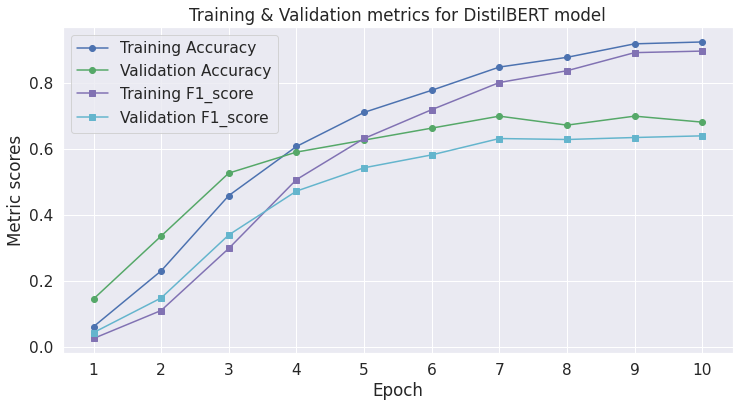

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.4)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(stats_df['Training Accuracy'], 'b-o', label="Training Accuracy")
plt.plot(stats_df['Validation Accuracy'], 'g-o', label="Validation Accuracy")
plt.plot(stats_df['Training F1'], 'm-s', label="Training F1_score")
plt.plot(stats_df['Validation F1'], 'c-s', label="Validation F1_score")

# Label the plot.
plt.title("Training & Validation metrics for DistilBERT model")
plt.xlabel("Epoch")
plt.ylabel("Metric scores")
plt.legend()
plt.xticks(np.arange(epochs), np.arange(1, epochs+1));

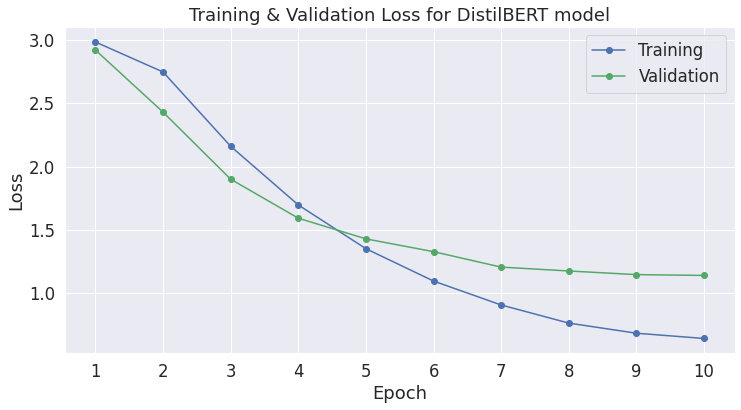

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(stats_df['Training Loss'], 'b-o', label="Training")
plt.plot(stats_df['Validation Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss for DistilBERT model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(np.arange(epochs), np.arange(1, epochs+1));


# Preparing Data for Testing

In [ ]:
def split_sequence(sequence):
  tokens = tokenizer.tokenize(sequence)
  chunks = [tokens[x:x+256] for x in range(0, len(tokens), 256)]
  return [' '.join(x).replace('##', '') for x in chunks]

In [ ]:
test_data_split = test_texts.apply(split_sequence)

In [ ]:
test_df = pd.DataFrame([test_texts, test_data_split, test_labels], index=['text', 'clean_split_text', 'label']).T
test_df.head()

,text,clean_split_text,label
0,respiratory morbidity and lung function analys...,[respiratory mor bid ity and lung function ana...,18
1,flavor techniques for lfv processes: higgs dec...,[flavor techniques for l f v processes : hi gg...,13
2,corrigendum: human milk oligosaccharide compos...,[co rri gen du m : human milk ol igo sa cc har...,18
3,obsessive–compulsive personality symptoms pred...,[ob ses sive – com pu ls ive personality sympt...,4
4,blood-brain barrier and delivery of protein an...,[blood - brain barrier and delivery of protein...,17


In [ ]:
candidate_labels = df.label_id.unique()
print(candidate_labels)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


# Testing the model

## Truncated text for first 512 tokens

In [ ]:
model.eval()

start = time.perf_counter() 

for index, data in test_df.iterrows():
  start_time = time.perf_counter() 

  label = data.label

  text = data.text

  # As entire text is passed the model truncates input to max_limit = 512 tokens
  results = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

  input_ids = results['input_ids'].to(device)
  attention_mask = results['attention_mask'].to(device)

  outputs = model(input_ids, attention_mask=attention_mask, labels=torch.tensor(label).to(device))

  prediction = outputs.logits.argmax(dim=-1).detach().cpu().numpy()[0]
  
  print(f'Index: {index}, True_label: {label}, Predicted_label {prediction}')

  test_metric_accuracy_512.add(prediction=prediction, 
                reference=label)
  test_metric_f1_512.add(prediction=prediction, 
                reference=label)

  stop_time = time.perf_counter() 

  # print('Time taken for testing: ', stop_time - start_time)

test_accuracy_512 = test_metric_accuracy_512.compute()
test_f1_512 = test_metric_f1_512.compute(average='macro')
  
print(f"Test metric Accuracy: {test_accuracy_512['accuracy']*100:.2f}")
print(f"Test metric F1_score: {test_f1_512['f1']*100:.2f}")

stop = time.perf_counter() 
# print('Total Test time: ', stop - start)

Index: 0, True_label: 18, Predicted_label 18
Index: 1, True_label: 13, Predicted_label 13
Index: 2, True_label: 18, Predicted_label 2
Index: 3, True_label: 4, Predicted_label 4
Index: 4, True_label: 17, Predicted_label 11
Index: 5, True_label: 18, Predicted_label 2
Index: 6, True_label: 15, Predicted_label 15
Index: 7, True_label: 8, Predicted_label 15
Index: 8, True_label: 8, Predicted_label 3
Index: 9, True_label: 4, Predicted_label 10
Index: 10, True_label: 1, Predicted_label 1
Index: 11, True_label: 9, Predicted_label 9
Index: 12, True_label: 15, Predicted_label 15
Index: 13, True_label: 8, Predicted_label 8
Index: 14, True_label: 5, Predicted_label 5
Index: 15, True_label: 9, Predicted_label 9
Index: 16, True_label: 11, Predicted_label 7
Index: 17, True_label: 3, Predicted_label 8
Index: 18, True_label: 15, Predicted_label 8
Index: 19, True_label: 13, Predicted_label 13
Index: 20, True_label: 3, Predicted_label 3
Index: 21, True_label: 0, Predicted_label 4
Index: 22, True_label: 0

## Testing for Long Text

In [ ]:
model.eval()

pred_labels = []
start = time.perf_counter() 

for index, data in test_df.iterrows():
  start_time = time.perf_counter() 

  # print(data.label)
  label = data.label

  # initialising a dictionary to store counts for label prediction for each text chunk
  pred_dict = dict.fromkeys(candidate_labels, 0)

  for split_text in data.clean_split_text:
    results = tokenizer(split_text, padding=True, truncation=True, return_tensors='pt')

    input_ids = results['input_ids'].to(device)
    attention_mask = results['attention_mask'].to(device)

    # print(input_ids)
    # print(attention_mask)

    outputs = model(input_ids, attention_mask=attention_mask, labels=torch.tensor(label).to(device))

    pred_chunk = outputs.logits.argmax(dim=-1).detach().cpu().numpy()
    # print('pred chunk:', pred_chunk)
    pred_dict[pred_chunk[0]] += 1

  # print(pred_dict)

  pred_label = max(pred_dict, key=pred_dict.get)
  
  print(f'Index: {index}, True_label: {label}, Predicted_label {pred_label}')

  pred_labels.append(pred_label)

  test_metric_accuracy.add(prediction=pred_label, reference=label)
  test_metric_f1.add(prediction=pred_label, reference=label)

  stop_time = time.perf_counter() 

  # print('Time taken for testing: ', stop_time - start_time)

test_accuracy = test_metric_accuracy.compute()
test_f1 = test_metric_f1.compute(average='macro')
  
print(f"Test metric Accuracy: {test_accuracy['accuracy']*100:.2f}")
print(f"Test metric F1_score: {test_f1['f1']*100:.2f}")

stop = time.perf_counter() 
# print('Total Test time: ', stop - start)

Index: 0, True_label: 18, Predicted_label 18
Index: 1, True_label: 13, Predicted_label 13
Index: 2, True_label: 18, Predicted_label 2
Index: 3, True_label: 4, Predicted_label 4
Index: 4, True_label: 17, Predicted_label 15
Index: 5, True_label: 18, Predicted_label 18
Index: 6, True_label: 15, Predicted_label 15
Index: 7, True_label: 8, Predicted_label 8
Index: 8, True_label: 8, Predicted_label 1
Index: 9, True_label: 4, Predicted_label 4
Index: 10, True_label: 1, Predicted_label 1
Index: 11, True_label: 9, Predicted_label 9
Index: 12, True_label: 15, Predicted_label 15
Index: 13, True_label: 8, Predicted_label 8
Index: 14, True_label: 5, Predicted_label 5
Index: 15, True_label: 9, Predicted_label 9
Index: 16, True_label: 11, Predicted_label 7
Index: 17, True_label: 3, Predicted_label 8
Index: 18, True_label: 15, Predicted_label 8
Index: 19, True_label: 13, Predicted_label 13
Index: 20, True_label: 3, Predicted_label 3
Index: 21, True_label: 0, Predicted_label 4
Index: 22, True_label: 0,

In [ ]:
metrics_table_df = pd.DataFrame(data=([np.round(test_accuracy_512['accuracy']*100,2),
                    np.round(test_f1_512['f1']*100,2)],
                   [np.round(test_accuracy['accuracy']*100,2),
                    np.round(test_f1['f1']*100,2)]), 
                    columns=['Accuracy', 'F1_score'], 
                    index=['Only first 512', 'Long text'])

metrics_table_df

,Accuracy,F1_score
Only first 512,64.86,63.27
Long text,63.06,59.11


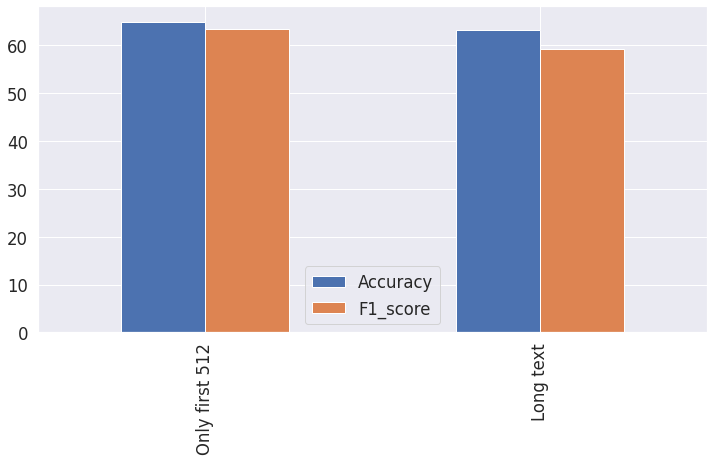

In [ ]:
metrics_table_df.plot(kind='bar');